# PID Control with Anti-Reset-Windup

## Additional Benefits of Tracking the Manipulated Variable

An extra **tracking** input was added in order to improve response when switching from manual to automatic control. This turns out to have additional benefits for the case where the controller would otherwise be requesting infeasible values for the manipulated variable.

The next simulation simply repeats the applies the tracking controller to the heater startup case.

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        t, PV, SP, TR = yield MV
        
        # adjust I term so output matches tracking input
        I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

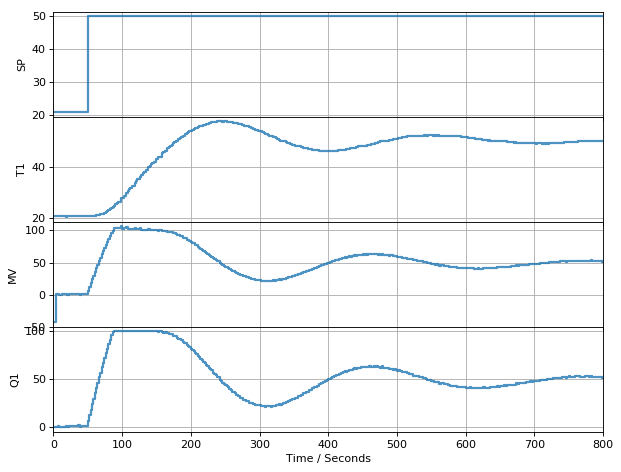

TCLab Model disconnected successfully.


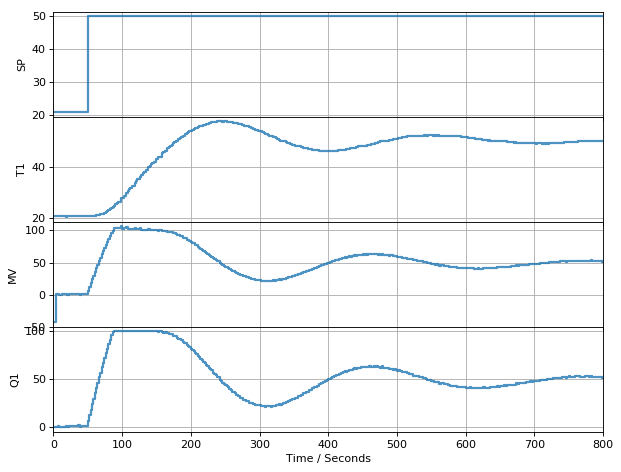

In [2]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

We observe markedly improved performance with less overshoot of the setpoint, less undershoot, and faster settling time.  

The reason for the improved response is that the integral term of the PID controller is constrained such that the manipulated variable remains within feasible limits. This important feature is called **anti-reset windup**.

## Embedding Anti-Reset Windup inside the Controller

The most common reason for a mismatch between the controller output and the actual value of the manipulated variable are the existence of hard limits on $MV$.  These hard limits can be enforced inside of the control algorithm which may, for some applications, eliminate the need for using the **tracking** input.

The next cell modifies our control algorithm to accomodate this feature, and automatically detects if a tracking signal is passed to the controller.

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        #I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

This version of the control is tested again with our startup example, but this time without using the tracking input to the controller. The results demonstrate the importance of anti-reset windup.

In [2]:
550 % 100

50

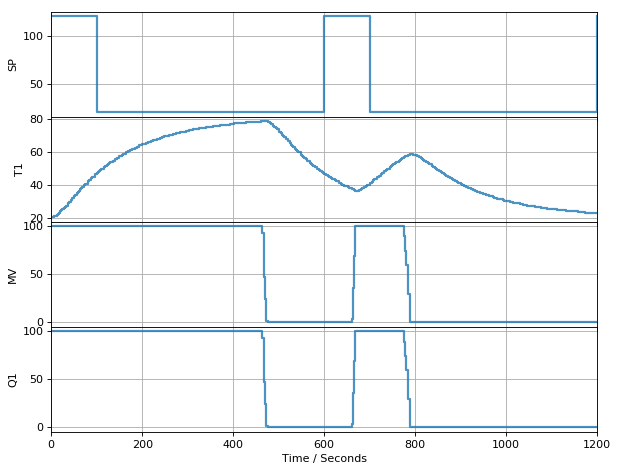

TCLab Model disconnected successfully.


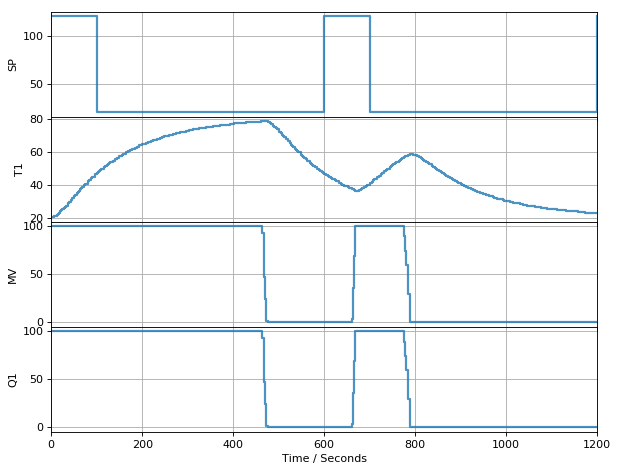

In [5]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(1, 0.2, 0, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    Tlo = lab.T1
    Thi = 120
    for t in clock(tfinal, 2):
        SP =  Thi if (t % 600 < 100) else Tlo                    # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

In [9]:
h.columns

['Time', 'SP', 'T1', 'MV', 'Q1']